In [1]:
### Collapse of an Homogeneous Sphere - Analysis code ### 

In [2]:
## Section 1 - Setting of useful parameters (Nparticles,TotMass,RadiusSphere,Nsnapshots,FreeFallTime) ##

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Number of particles, total mass and radius of the sphere at t=0
Nparticles,M,radius = np.loadtxt('system_properties.txt')
Nparticles = int(Nparticles)
m = M/Nparticles # mass of a single particle

Nlines_in_snapshot = 3+4*Nparticles # Nparticles(1row)+Ndimensions(1)+time(1)+mass_particles(N)+
                                    # +positions(N)+velocities(N)+potential_energy(N)

## Number of snapshot in 'output_data.txt'
data = open("output_data.txt", "r")	
Nlines = len(data.readlines())
Nsnapshots = Nlines/Nlines_in_snapshot # total number of temporal steps saved 
Nsnapshots = int(Nsnapshots)
data.close()

## Free fall time of the sphere
density = M/(4/3*math.pi*radius**3) # mass density of the sphere
t_collapse = math.sqrt( (3*math.pi)/(32*density))

In [10]:
## Section 2 - Definition and filling of the time array ## 

In [11]:
t = np.empty([Nsnapshots])
for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_time = initial_line+2
    t[i_snapshot] = np.genfromtxt("output_data.txt",skip_header=initial_line_time,max_rows=1)

In [6]:
## Section 3 - Energy section ##

In [7]:
# In this Section are computed, for each time step the total kinetic and the total potential energies per unit mass.
# Pay attention that the computational time for these part is quite long (as the amount of particles and the number 
# of snapshots increase, so will do the computational time)
# The kinetic energy, the potential energy and the total energy (sum of the previous ones) are then plotted respect
# to time.
# The total energy, in principle, should be preserved at every time and should be equal to the total energy at t=0;
# for this reason is presented the graph of 'Etot(t)-Etot(t=0) vs. time' that gives an idea of the conservation
# of energy deviation (the non perfect conservation of energy is due to computational approximations)


In [8]:
## Definiton and filling of the kinetic and potential energies at each time step
Utot = np.zeros([Nsnapshots])
Ktot = np.zeros([Nsnapshots])

for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_velocity = initial_line+3+2*Nparticles
    initial_line_potential = initial_line+3+3*Nparticles
    for i_particle in range(Nparticles):            
        vx = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=0,max_rows=1) # i_particle's x_velocity at time=t[i_snapshot]
        vy = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=1,max_rows=1)
        vz = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=2,max_rows=1)        
        Utot[i_snapshot] = Utot[i_snapshot]+np.genfromtxt("output_data.txt",skip_header=initial_line_potential+i_particle,max_rows=1)
        Ktot[i_snapshot] = Ktot[i_snapshot]+0.5*(vx**2 + vy**2 + vz**2)             
Utot = Utot*0.5 # to avoid the double counting for the potential energy  

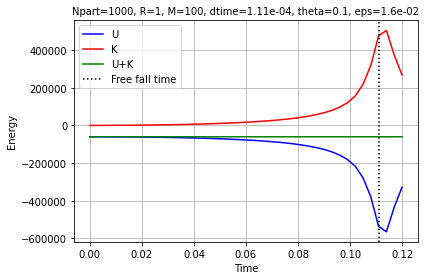

In [9]:
## Plot of the ptential energy (U), kinetic energy(K), total energy(U+K)
plt.title('Npart=1000, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=1.6e-02', fontsize=10,loc='center', pad=None)
plt.plot(t,Utot,c='b',label='U')
plt.plot(t,Ktot,c='r',label='K')
plt.plot(t,Ktot+Utot,c='g',label='U+K')
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('energy_plot_1000.jpg')

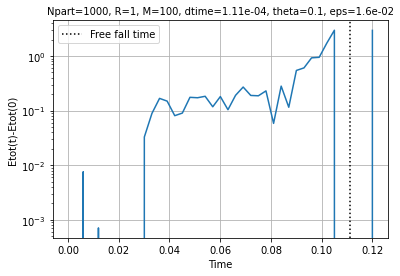

In [10]:
## Plot of 'TotalEnergy(t)-TotalEnergy(t=0)  vs. Time'
diff = (Utot+Ktot)-(Utot[0]+Ktot[0])
plt.plot(t,diff)
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.title('Npart=1000, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=1.6e-02', fontsize=10,loc='center', pad=None)
plt.xlabel('Time')
plt.ylabel('Etot(t)-Etot(0)')
plt.yscale('log')
plt.grid()
plt.legend(loc='best')
plt.savefig('energy_diff_plot_1000.jpg')

In [11]:
## Section 3 - Position section ##

In [12]:
# This Section is divided into four subsections
# -Subsection 1: Among the particles, Nsamples are selected and at each time step their distance is computed respect 
#                to the center (the distance is saved into an array D([Nsnapshots,Nsamples]) ).
#                The samples are not chosen by random sampling, but using a particular process:
#                first I choose the number n of samples that I want to analyse and then I split sphere's radius 
#                at t=0 in n intervals. For each interval I take a particle that at t=0 belongs to it and 
#                if the code cannot find any particle, it is chosen randomly. Thanks to this process we have a 
#                better sample of particles within the radius, respect to a random selection. 
#                Advise: for computational costs and for plotting clarity is convenient to choose a small sample

# -Subsection 2: Among the particles, Nsamples are selected (not the same of the previous subsection and, usually
#                a bigger number) and their distance from the center is computed at the free fall time; the distances
#                obtained are used to compute the mean distance of the particles from the center at t=t_free_fall.
#                Our aim is to analyze how this mean distance (that theorically should be equal to 0) is improved 
#                using a bigger number of particles (Nparticles) to approximate the sphere.

# -Subsection 3: we compare qualitatively the theorical and the computed evolution over time of the radius of one
#                sample particle

# -Subsection 4: Lagrangian Radius and Center of mass analysis

In [13]:
# -Subsection 1 #

In [14]:
Nsamples = 5
delta = radius/Nsamples 
sample_index = np.ones([Nsamples])*(-1) # array where will be saved the indexes of the particles chosen as samples
                                        # initialized in this way for the while cicle that follows
for i in range(Nsamples):
    i_particle = 0      
    while (sample_index[i]==-1) == True:
        x = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+i_particle,usecols=0,max_rows=1)
        y = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+i_particle,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+i_particle,usecols=2,max_rows=1)
        dist = (x**2+y**2+z**2)**(1/2)              
        if dist<=(radius-delta*i) and dist>(radius-delta*(i+1)):
            sample_index[i] = i_particle
        elif i_particle == Nparticles-1:
            sample_index[i] = np.random.randint(0, Nparticles-1) # random selection
        else: i_particle = i_particle+1

# The code written above should be improved as follow: selection of a particle, computation of its distance respect
# to the center and association to the corrispondent radius interval (if no particle has been associated yet); in
# the code above instead when a particle is found, the search for the other one restarts from the beginning.

In [15]:
## saving the Nsamples' positions, at each snapshot, in D (they'll be plotted later)
D = np.empty([Nsnapshots,Nsamples]) 
for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_position = initial_line+3+Nparticles
    for i_sample in range(Nsamples):
        i_particle = int(sample_index[i_sample])
        x = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=0,max_rows=1)
        y = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=2,max_rows=1)
        D[i_snapshot][i_sample] = (x**2+y**2+z**2)**(1/2)

In [16]:
# -Subsection 2- #

In [17]:
## Distance from the center at t=t_free_fall
Nsamples = 100 # must be less or equal to the Nparticles
Dist_media = 0
sample_index = np.empty([Nsamples]) # array where will be saved the indexes of the particles chosen as samples
for i in range(Nsamples):
    sample_index[i] = np.random.randint(0, Nparticles-1) # random selection

In [18]:
## selection of the number of the snapshot s.t. t[selected_snapshot] is the closest (or luckily equal)
## to t_free_fall
boolArr = t[(t >= t_collapse-0.000111) & (t <= t_collapse+0.000111)] 
location = np.where(t == boolArr)[0][0] # since boolArr is an array
initial_line = location*Nlines_in_snapshot
initial_line_position = initial_line+3+Nparticles
for i_sample in range(Nsamples):
    i_particle = int(sample_index[i_sample])
    x = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=0,max_rows=1)
    y = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=1,max_rows=1)
    z = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=2,max_rows=1)
    Dist_media = Dist_media+(x**2+y**2+z**2)**(1/2)
Dist_media = Dist_media/Nsamples

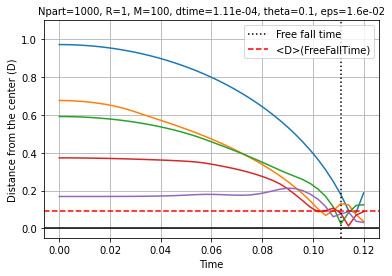

In [19]:
## Plot of the evolution of the distance over time of the samples and of the mean distance at t=t_free_fall 
plt.title('Npart=1000, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=1.6e-02', fontsize=10,loc='center', pad=None)
plt.plot(t,D)
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.axhline(0,0,1,c='k',ls='-')
plt.axhline(Dist_media,0,1,c='r',ls='--',label='<D>(FreeFallTime)') 
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.ylim([-0.05,radius+0.1])
plt.grid()
plt.legend(loc='best')
plt.savefig('position_plot_1000.jpg')

In [20]:
## Plot of the mean distance of the particles at t=t_free_fall respect to the number of particles
## As can be seen, we obtain a decreasing trend, as expexted since the more particles are used, the better the 
## approximation is.
## The data plotted have been collected in different simulations for a sphere of R=1 and M=100, using dtime=1.11e-04, 
## theta=0.1 and eps=(mean_particle_separation)/10

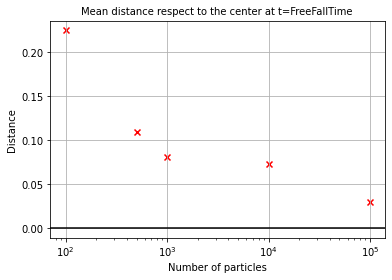

In [21]:
distanza=[0.22488179817415882,0.10882063572246285,0.08138094041653397,0.07266183482984993,0.029597061024799504]
particelle=[100,500,1000,10000,100000]
eps=[0.03,0.02,0.016,0.007,0.0035]
plt.scatter(particelle,distanza,marker='x',color='r')
plt.title('Mean distance respect to the center at t=FreeFallTime ', fontsize=10,loc='center', pad=None)
plt.axhline(0,0,1,c='k',ls='-')
plt.xscale('log')
plt.xlabel('Number of particles')
plt.ylabel('Distance')
plt.grid()
plt.savefig('mean_distance_particles.jpg')

In [22]:
# -Subsection 3- # 

In [23]:
## Computation of the theorical prediction
# We select a sample particle and compare through a plot, qualitatively, the evolution of its distance from the
# center with the theorical prediction. For the sample we selected one already find in Subsection 1: its distance
# is saved in the f array; the sample chosen can be changed simply changing 'value' in D[i]['value'] in the for
# that follows
f = np.empty([Nsnapshots]) 
for i in range(Nsnapshots):
    f[i] = D[i][0] 
R0 = f[0] # starting radius 
R = np.linspace(R0,0,len(t[t<=t_collapse]))
T=-(np.arcsin(np.sqrt(R/R0)) - math.pi/2 - np.sqrt(R/R0)*np.sqrt(1-R/R0))/math.sqrt(8/3*math.pi*density) # from theory


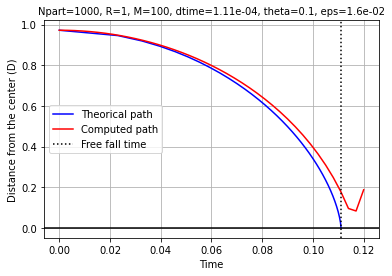

In [24]:
## Plot of the theorical and the computed paths
plt.plot(T,R,label='Theorical path',color='b')
plt.plot(t,f,label='Computed path',color='r')
plt.title('Npart=1000, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=1.6e-02', fontsize=10,loc='center', pad=None)
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.axhline(0,0,1,c='k',ls='-')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.grid()
plt.legend(loc='best')
plt.savefig('theoricalvscomputed_1000.jpg')

In [12]:
# -Subsection 4- #

In [13]:
## definition of the Center of Mass and of the Lagrangian Radius Arrays 
CoM = np.empty([Nsnapshots]) 
LagRad20 = np.empty([Nsnapshots])
LagRad40 = np.empty([Nsnapshots])
LagRad60 = np.empty([Nsnapshots])
LagRad80 = np.empty([Nsnapshots])
LagRad100 = np.empty([Nsnapshots])

dist = np.empty([Nparticles])
for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_position = initial_line+3+Nparticles
    CoM_x = 0
    CoM_y = 0
    CoM_z = 0
    for i_particle in range(Nparticles):
        x = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=0,max_rows=1)
        y = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=2,max_rows=1)
        dist[i_particle] = (x**2+y**2+z**2)**(1/2)
        CoM_x = CoM_x+x
        CoM_y = CoM_y+y
        CoM_z = CoM_z+z
    sortArray = np.sort(dist)
    LagRad20[i_snapshot] = sortArray[int(0.2*Nparticles)-1]
    LagRad40[i_snapshot] = sortArray[int(0.4*Nparticles)-1]
    LagRad60[i_snapshot] = sortArray[int(0.6*Nparticles)-1]
    LagRad80[i_snapshot] = sortArray[int(0.8*Nparticles)-1]
    LagRad100[i_snapshot] = sortArray[-1]
    CoM_x = CoM_x/Nparticles
    CoM_y = CoM_y/Nparticles
    CoM_z = CoM_z/Nparticles
    CoM[i_snapshot] = (CoM_x**2+CoM_y**2+CoM_z**2)**(1/2)
    

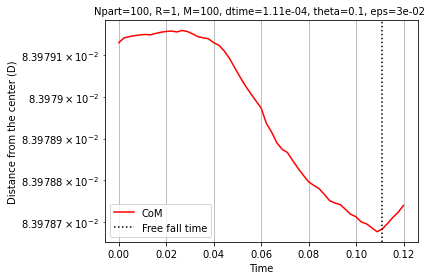

In [16]:
## Plot of the Center of Mass' distance respect to the center
plt.plot(t,CoM,color='r',label='CoM')
plt.title('Npart=100, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=3e-02 ', fontsize=10,loc='center', pad=None)
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.yscale('log')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('CoM(100).jpg')

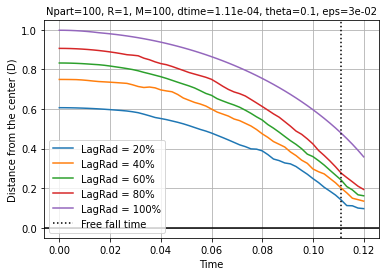

In [17]:
## Plot of the Lagrangian radiuses
plt.plot(t,LagRad20,label='LagRad = 20%')
plt.plot(t,LagRad40,label='LagRad = 40%')
plt.plot(t,LagRad60,label='LagRad = 60%')
plt.plot(t,LagRad80,label='LagRad = 80%')
plt.plot(t,LagRad100,label='LagRad = 100%')
plt.grid()
plt.title('Npart=100, R=1, M=100, dtime=1.11e-04, theta=0.1, eps=3e-02', fontsize=10,loc='center', pad=None)
plt.axhline(0,0,1,c='k',ls='-')
plt.axvline(t_collapse,0,1,label='Free fall time',c='k',ls=':')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.legend(loc='best')
plt.savefig('LagrangianRadius(100).jpg')